In [1]:
"""This code takes some time to run due to the high number of sampled data points
and the high number of state with the same velocity
Decrease T = 1000000 for quicker but less accurate empirical PDF
or reduce the number of points evaluated in the grid increasing the skip in minmax
from 5 e.g. to 10"""

#importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import ImageGrid

#getting current directory
import os
cwd = os.getcwd()

#importing all the functions contained in "functions.py"
%run ../functions

In [2]:
#time lengths
delta_t = 0.3 
T = 1000000

#define parameters of the six-state model
V = np.array([2000, -1500, 0, 0, 0, 0])
Lambda = np.array([1, 0.5, 0.3, 2, 2.2, 1.8])
P = np.array([[0.0, 0.0, 0.0, 0.2, 0.8, 0.0],
              [0.0, 0.0, 0.0, 0.2, 0.0, 0.8],
              [0.0, 0.0, 0.0, 0.0, 0.6, 0.4],
              [0.6, 0.4, 0.0, 0.0, 0.0, 0.0],
              [0.8, 0.0, 0.2, 0.0, 0.0, 0.0],
              [0.0, 0.8, 0.2, 0.0, 0.0, 0.0]])
sigma = 50
n = Lambda.shape[0]

#running the model
x_sim, y_sim, t_sim, sw, st = n_state_model(delta_t, T, V, Lambda, P, sigma)

#constructing the increments
delta_y = np.array([y_sim[i]-y_sim[i-1] for i in range(1, len(y_sim))])

#define points for which we need the PDF approximation  
minmax = np.arange(np.min(delta_y), np.max(delta_y)+1, 5)
X, Y = np.meshgrid(minmax, minmax)

#computing the approximate PDF for independent case P1(Delta y_1)P1(Delta y_2)
approx_pdf_ind_semires = np.array([approx_pdf_up_to_1_switch(V, Lambda, P, sigma,
                                                             delta_t, x)
                                   for x in X])
approx_pdf_ind_res = np.multiply(approx_pdf_ind_semires.T, approx_pdf_ind_semires)

#computing the approximate PDF P1(Delta y_1, Delta y_2)
approx_pdf_track_res = np.array([[np.prod(approx_pdf_track_up_to_1_switch(V, Lambda,
                                                                          P, sigma,
                                                                          delta_t, 
                                                           np.array([X[i,j], Y[i,j]])))
                                  for i in range(X.shape[0])]
                                 for j in range(X.shape[0])])

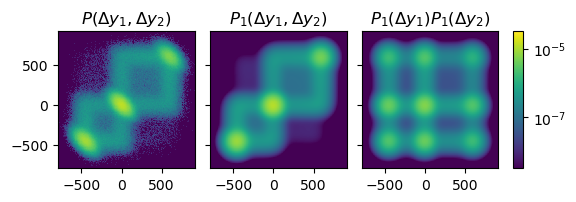

In [4]:
fig = plt.figure(figsize=(6,2))
ax = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15)
ax[0].hist2d(delta_y[1:], delta_y[0:-1], density=True, bins=250,
           norm=colors.LogNorm(vmin=10**(-8.5), vmax=10**(-4.5)))
ax[0].set_title(r'$P(\Delta y_1, \Delta y_2)$')
#ax[0].set_xlabel(r'$\Delta y_2$')
#ax[0].set_ylabel(r'$\Delta y_1$')
ax[0].set_facecolor('#440154FF')

ax[1].pcolor(X, Y, approx_pdf_track_res.T,
             norm=colors.LogNorm(vmin=10**(-8.5), vmax=10**(-4.5)))
ax[1].set_title('$P_1(\Delta y_1,\Delta y_2)$')
#ax[1].set_xlabel(r'$\Delta y_2$')

pcm = ax[2].pcolor(X, Y, approx_pdf_ind_res,
                   norm=colors.LogNorm(vmin=10**(-8.5), vmax=10**(-4.5)))
ax[2].set_title('$P_1(\Delta y_1) P_1(\Delta y_2)$')
#ax[2].set_xlabel(r'$\Delta y_2$')


ax[2].cax.colorbar(pcm)
ax[2].cax.toggle_label(True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig("P_Deltay_1,Deltay_2_all_6.png",
            format="png", bbox_inches="tight", dpi=1200)